# Train Data Maker

This notebook creates a training dataset to feed into the AP-SVM model. First, we load modules and files.

In [3]:
# Load modules 

import pickle, time, os, json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pygama import lgdo
import pygama.pargen.dsp_optimize as opt

# Set defaults for figures 
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='bright')
plt.style.use('/global/homes/e/esleon97/clint.mpl')
    
# Set directories
lgnd_data_dir = "/global/cfs/projectdirs/m2676/data/lngs/l200/public/prodenv"
run = "/phy/p03/r003/"
raw_dir = lgnd_data_dir + "/prod-orig/archive/raw-v01.00/generated/tier/raw" + run
dsp_dir = lgnd_data_dir + "/prod-blind/ref/v01.03/generated/tier/dsp" + run
hit_dir = lgnd_data_dir + "/prod-blind/ref/v01.03/generated/tier/hit" + run

# Set files
raw_files = sorted([os.path.abspath(os.path.join(raw_dir, p)) for p in os.listdir(raw_dir)])
dsp_files = sorted([os.path.abspath(os.path.join(dsp_dir, p)) for p in os.listdir(dsp_dir)])
hit_files =sorted([os.path.abspath(os.path.join(hit_dir, p)) for p in os.listdir(hit_dir)])

sto = lgdo.LH5Store()
with open('./dsp_config_dwt.json') as dsp:
    dsp_config = json.load(dsp)

# sto.gimme_file(dsp_files[0], 'r').keys() # Useful to look at what is in the files

Next we construct a list of **usable** Germanium detectors corresponding to the period and run we want to analyze. For this, we need configuration files from the ```legend_dataflow_config``` and ```legend_hardware_config``` repositories. The user should copy these files into the ```data``` directory.

In [4]:
# Include baseline, pulser, and muon trigger channels

ch_list = ['ch1027200', 'ch1027201', 'ch1027202']

with open('../data/l200-p03-r%-T%-all-config.json') as hw:
    hw_config = json.load(hw)
with open('../data/L200-p03-r000-T%-all-config.json') as df:
    df_config = json.load(df)

key_list = df_config['analysis'].keys()

for key in key_list:
    
    if key[0] in ['V','P','C','B']:
        if df_config['analysis'][key]['usability'] == 'on':
            rawid = 'ch' + str(hw_config[key]['daq']['rawid'])
            ch_list.append(rawid)

Here we load a specified number of cycles. Each background cycle contains about 2,000 waveforms. We need 10,000 waveforms from all detectors in total, so reading in 10 files is more than enough.  

In [12]:
n_files = 10
raw_files_in = raw_files[0:n_files]
dsp_files_in = dsp_files[0:n_files]
hit_files_in = hit_files[0:n_files]

bltrigger_dict = lgdo.load_nda(raw_files_in, ['daqenergy'], ch_list[0] + '/raw')
pulser_dict = lgdo.load_nda(raw_files_in, ['daqenergy'], ch_list[1] + '/raw')
muon_dict = lgdo.load_nda(raw_files_in, ['daqenergy'], ch_list[2] + '/raw')

Now we eliminate triggers from baseline, pulser, and muon channels.

In [13]:
idxs_pass = np.where((pulser_dict['daqenergy'] == 0) 
                     & (bltrigger_dict['daqenergy'] == 0)
                     & (muon_dict['daqenergy'] == 0))[0]

Once we remove auxiliary triggers, we can construct the train dataset. We evenly select waveforms from all usable Germanium detectors. For each detector, we choose half of the waveforms with ```daqenergy = 0``` and the other half with ```daqenergy > 0```. The ```dsp_config_dwt.json``` file contains a minimal list of **dsp** processors to perform a Discrete Wavelet Transform (DWT) on the selected waveforms. We include other parameters from the **raw** and **hit** tiers in the dataset as well. This step should take between 1-5 minutes, depending on how many files we load in. 

In [16]:
import logging, sys
logging.disable(sys.maxsize) #ignore logger warnings

dwt_norm_list, wf_norm_list = [], []
cuspEmax_ctc_cal_list, daqenergy_list, channel_list =  [], [], []

n_max = round(5000/len(ch_list[3:]))

start_time = time.time()
    
for ch in ch_list:

    if ch in ['ch1027200', 'ch1027201', 'ch1027202']:
        continue
        
    tb_pass, _ = sto.read_object(ch + '/raw/daqenergy', raw_files_in, idx=idxs_pass)
    daqenergies = tb_pass.nda
    idxs_hi, idxs_lo = np.where(daqenergies > 0)[0][0:n_max], np.where(daqenergies == 0)[0][0:n_max]
    
    tb_raw_hi, n_hi = sto.read_object(ch + '/raw', raw_files_in, idx=idxs_pass[idxs_hi])
    tb_raw_lo, n_lo = sto.read_object(ch + '/raw', raw_files_in, idx=idxs_pass[idxs_lo])
    tb_hit_hi, _ = sto.read_object(ch + '/hit/cuspEmax_ctc_cal', hit_files_in, idx=idxs_pass[idxs_hi])
    tb_hit_lo, _ = sto.read_object(ch + '/hit/cuspEmax_ctc_cal', hit_files_in, idx=idxs_pass[idxs_lo])
    tb_dwt_hi = opt.run_one_dsp(tb_raw_hi, dsp_config)
    tb_dwt_lo = opt.run_one_dsp(tb_raw_lo, dsp_config)
    # print(ch, n_hi, n_lo) # Useful to check if enough events are being read

    daqenergy_hi = tb_raw_hi['daqenergy'].nda
    cuspEmax_ctc_cal_hi = tb_hit_hi.nda
    wf_norm_hi = tb_dwt_hi['wf_norm']['values'].nda
    dwt_norm_hi = tb_dwt_hi['dwt_norm'].nda
    channel_hi = tb_raw_hi['channel'].nda
    
    daqenergy_lo = tb_raw_lo['daqenergy'].nda
    cuspEmax_ctc_cal_lo = tb_hit_lo.nda
    wf_norm_lo = tb_dwt_lo['wf_norm']['values'].nda
    dwt_norm_lo = tb_dwt_lo['dwt_norm'].nda
    channel_lo = tb_raw_lo['channel'].nda



    for i in range(len(daqenergy_hi)):

        daqenergy_list.append(daqenergy_hi[i])
        cuspEmax_ctc_cal_list.append(cuspEmax_ctc_cal_hi[i])
        channel_list.append(channel_hi[i])
        dwt_norm_list.append(dwt_norm_hi[i])
        wf_norm_list.append(wf_norm_hi[i])
    
    for j in range(len(daqenergy_lo)):
        
        daqenergy_list.append(daqenergy_lo[i])
        cuspEmax_ctc_cal_list.append(cuspEmax_ctc_cal_lo[i])
        channel_list.append(channel_lo[i])
        dwt_norm_list.append(dwt_norm_lo[i])
        wf_norm_list.append(wf_norm_lo[i])
        
print("--- %s minutes elapsed ---" % ((time.time() - start_time)/60))

--- 4.67333376010259 minutes elapsed ---


We now save the waveforms, DWTs, and other parameters into a data dictionary. We also look at the energy spectrum of the dataset and at sample waveforms as a sanity check.

In [19]:
data_dict = {
    "dwt_norm": np.array(dwt_norm_list),
    "wf_norm": np.array(wf_norm_list),
    "daqenergy": np.array(daqenergy_list),
    "cuspEmax_ctc_cal": np.array(cuspEmax_ctc_cal_list),
    "channel": np.array(channel_list)
}

(9269,)


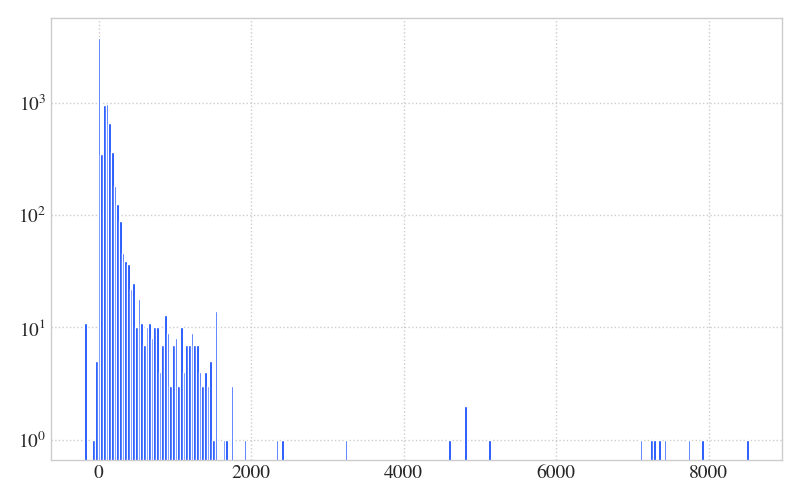

In [21]:
%matplotlib widget

plt.hist(data_dict['cuspEmax_ctc_cal'], bins=250)
plt.yscale('log')
print(data_dict['cuspEmax_ctc_cal'].shape)

(4247,)


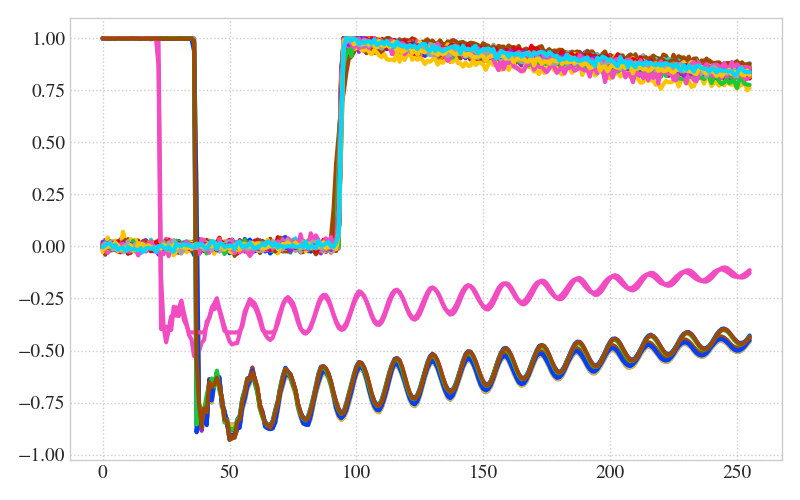

In [24]:
%matplotlib widget
fig, ax = plt.subplots(1,1)

sel = np.where(data_dict['daqenergy'] > 0)[0]
print(sel.shape)
for i in sel[0:100]:
    ax.plot(data_dict['dwt_norm'][i])

In [15]:
with open('p03_r003_train_data.pickle', 'wb') as handle:
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)